# Tutorial Notebook for PSISIM MODHIS VFN Mode
This notebook shows how psisim can be used to a simulated observation with VFN on MODHIS. It is a direct analog to the PSISIM HISPEC Tutorial notebook.

First import all the things and setup the plot things

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 

SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/usr/local/lib/python3.6/dist-packages/pysynphot/locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.6/dist-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Initial Setup

Setup the path to the peripheral files and load in the filter objects from speclite

In [2]:
path = '/scr3/dmawet/ETC/'
filters = spectrum.load_filters()

## Telescope Setup

A *telescope* object contains the telecope parameters, the site characteristics and the current conditions. 

In [3]:
tmt = telescope.TMT(path=path)
tmt.airmass=1.1
tmt.water_vapor=1.6
tmt.seeing = tmt.median_seeing

## Instrument Setup

An _instrument_ object contains both the static instrument parameters, as well as the current observing setup

In [4]:
#Initialize a modhis object and set the current filter
modhis = instrument.modhis(telescope=tmt)
modhis.set_current_filter("TwoMASS-K")

#Get the set of wavelengths based on the current instrument setup
wavelengths = modhis.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), # of Exposures, filter name, wavelength array, mode, charge for VFN
modhis.set_observing_mode(2*3600, 1,'TwoMASS-K', wavelengths,mode="vfn",vortex_charge=1) 

MODHIS is mostly untested at this point


## Generate some Spectra

We can now generate a host spectrum. Host properties taken from Dimitri's VFN notebook.

In [5]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.00*u.dex(u.cm/u.s**2),"StarTeff":4400*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                    "StarRadialVelocity":-50*u.km/u.s,
                    "StarVsini":10*u.km/u.s,
                    "StarLimbDarkening":0.2}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-K',5.0,filters,modhis.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=modhis.current_dwvs)


/usr/local/lib/python3.6/dist-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Plot the Spectrum!

Text(0.5, 1.0, 'Host Spectrum')

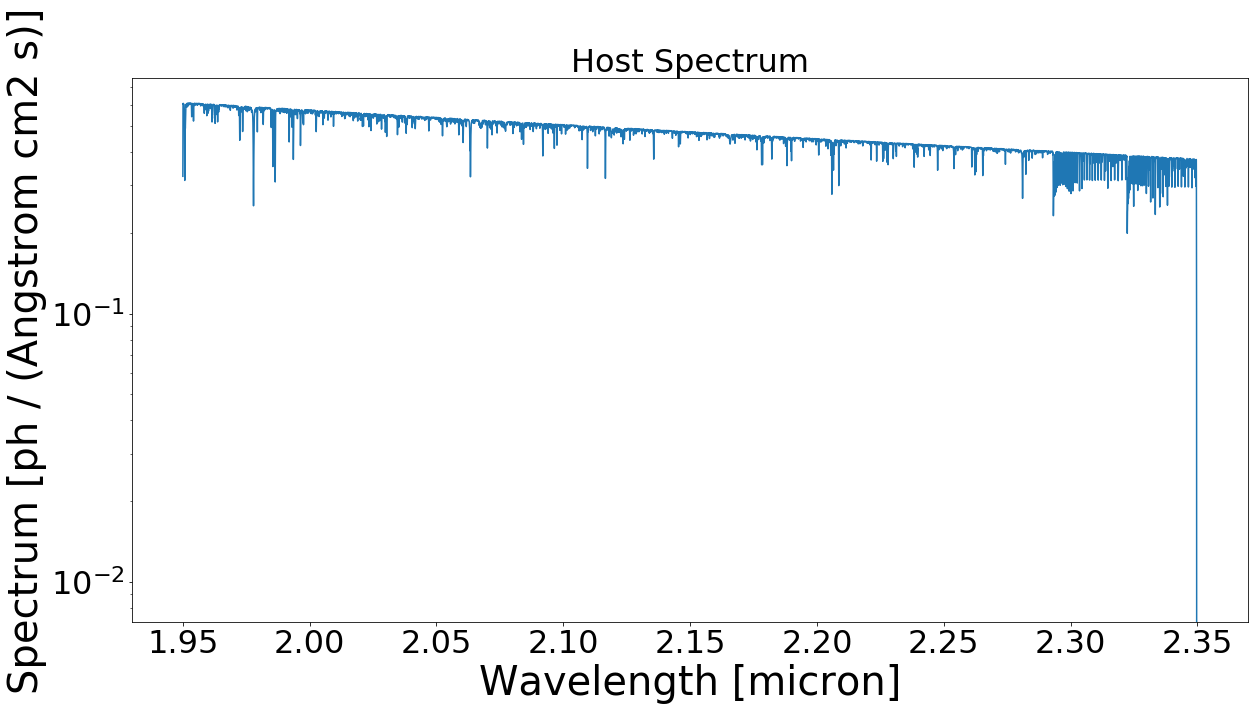

In [6]:
plt.figure(figsize=(20,10))

plt.semilogy(wavelengths,host_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(host_spectrum.spectrum.unit))
plt.title("Host Spectrum")

Now we can generate a target spectrum as well. Target properties taken from Dimitri's VFN notebook.

In [7]:
obj_properties = {"StarLogg":3.25*u.dex(u.cm/u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":10*u.km/u.s,"StarVsini":8*u.km/u.s,
                  "StarLimbDarkening":0.2}

obj_user_params = (path,'TwoMASS-K',18,filters,modhis.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,modhis.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=modhis.current_dwvs)

Text(0.5, 1.0, 'Target Object Spectrum')

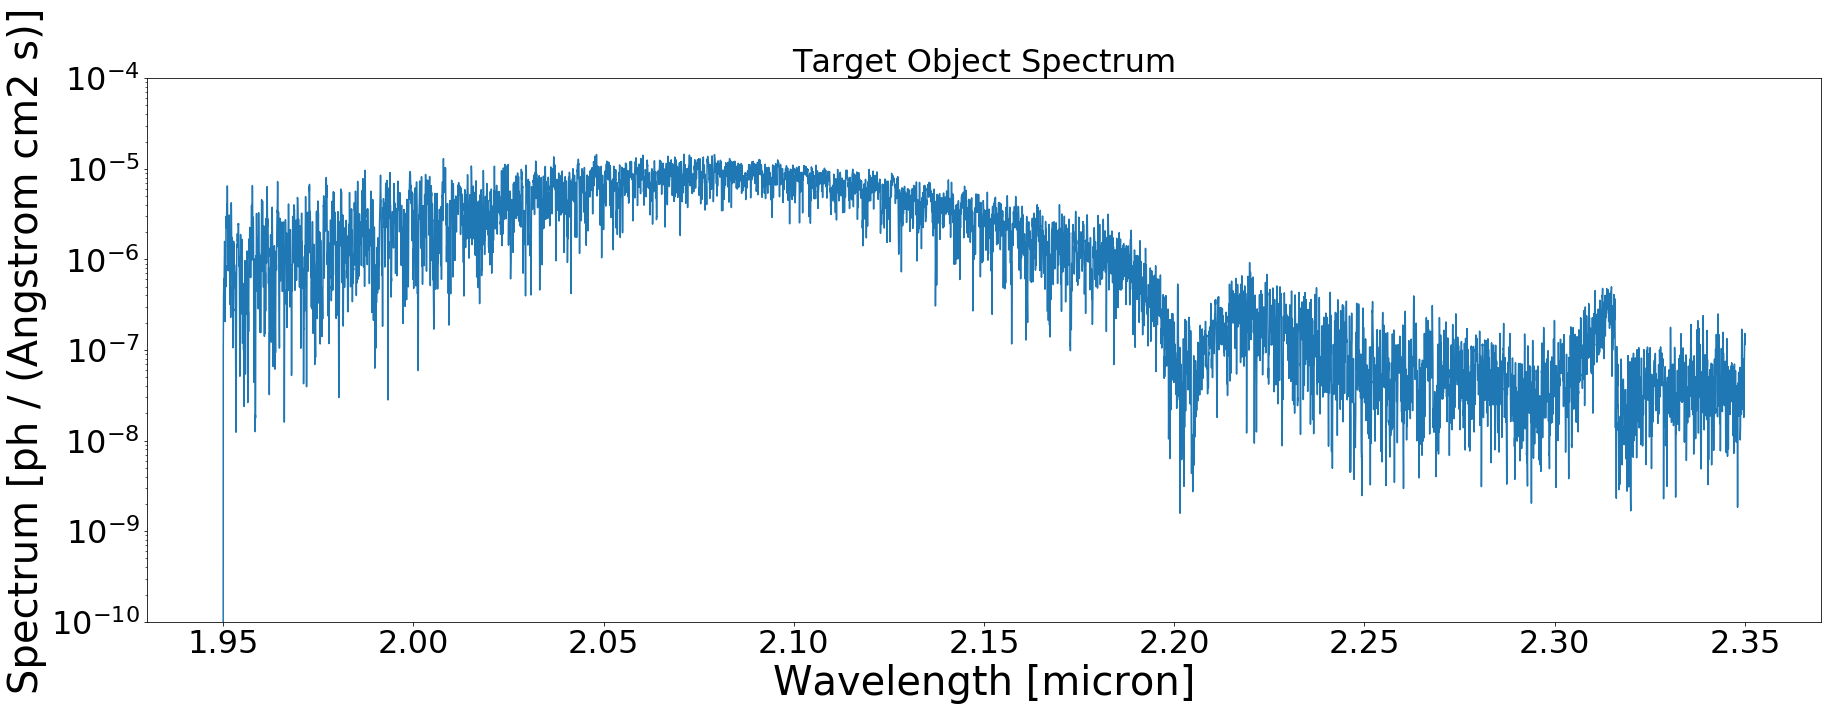

In [8]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spectrum.spectrum.unit))
plt.ylim(1e-10,1e-4)
plt.title("Target Object Spectrum")

### Because of the original PSISIM design considerations, we want the object spectrum in contrast units

In [9]:
obj_spectrum.spectrum /= host_spectrum.spectrum

/home/aidan/.local/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'Host-Target Contrast Spectrum')

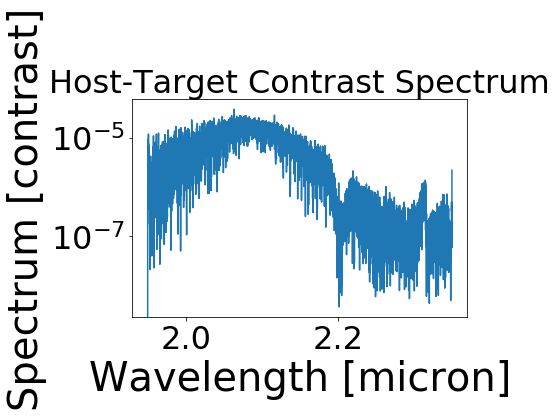

In [10]:
plt.semilogy(wavelengths,obj_spectrum.spectrum)
plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [contrast]")
plt.title("Host-Target Contrast Spectrum")

# Simulate an observation

First set some extra parameters

In [11]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 15*0.9 *u.mas  # 0.9lam/D is the peak planet location for charge 1 and 15mas is 1lam/D at 2um (k-band)

# Convert angular sep to arcseconds for repeated use later in the script
planet_sep = host_properties['AngSep'].to(u.arcsec)

# Set the host star's angular diameter, which defines the nulling geometric leakage
host_diam = 1 *u.mas  
modhis.set_vfn_host_diameter(host_diam)

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[modhis.ao_filter], model='Phoenix',
                                                         verbose=False,user_params = host_user_params)
modhis.ao_mag = host_properties["StarAOmag"]

#KPIC doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

## Actually simulate the observation 

In [12]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(tmt,modhis,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False)

/home/aidan/.local/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Plot it!

Text(0.5, 1.0, 'Observed Spectrum')

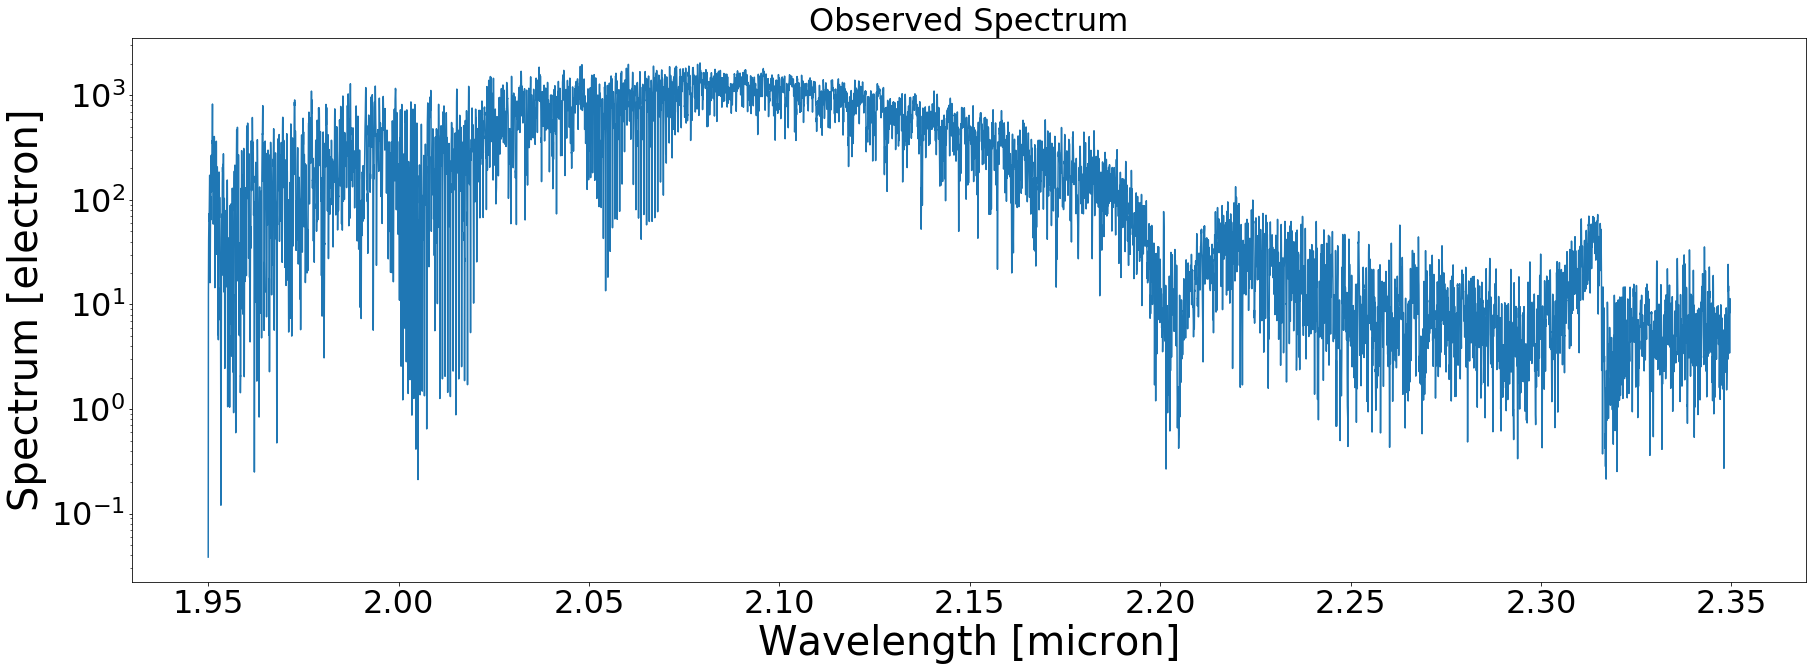

In [13]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
plt.title("Observed Spectrum")
#plt.ylim(1e-3,5e2)

## Now let's cycle through the available filters and collect all the results 

In [14]:
all_wavelengths = []
full_host_spectrum = []
full_obj_spectrum = []
full_obj_spectrum_nosky = []
full_total_noise = []
full_thermal_spec = []
full_noise_components = []
full_speckle_noise = []


for modhis_filter in modhis.filters:
    
    #Setup the instrument
    modhis.set_current_filter(modhis_filter)
    wavelengths = modhis.get_wavelength_range()
    modhis.set_observing_mode(2*3600,1,modhis_filter, wavelengths,mode="vfn",vortex_charge=1) 
    
    
    host_user_params = (path,'TwoMASS-K',5.0,filters,modhis.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=modhis.current_dwvs)
    
    obj_user_params = (path,'TwoMASS-K',18,filters,modhis.current_filter)
    obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,modhis.current_R,model="Sonora",
                                                 user_params=obj_user_params,doppler_shift=True,broaden=True,
                                                 delta_wv=modhis.current_dwvs)

    obj_spectrum.spectrum /= host_spectrum.spectrum
    
    obj_spec,total_noise,stellar_spec,thermal_spec,noise_components= observation.simulate_observation(tmt,modhis,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=True)
    obj_spec_no_sky,_,_,_ = observation.simulate_observation(tmt,modhis,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=False,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=False)

    full_speckle_noise.append(modhis.get_speckle_noise(planet_sep,host_properties['StarAOmag'],modhis.current_filter,wavelengths,host_properties['StarSpT'],tmt)[0])
    all_wavelengths.append(wavelengths)
    full_host_spectrum.append(stellar_spec)
    full_obj_spectrum.append(obj_spec)
    full_obj_spectrum_nosky.append(obj_spec_no_sky)
    full_total_noise.append(total_noise)
    full_thermal_spec.append(thermal_spec)
    full_noise_components.append(noise_components)

all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_host_spectrum = np.hstack(full_host_spectrum).value*stellar_spec.unit
full_obj_spectrum = np.hstack(full_obj_spectrum).value*obj_spec.unit
full_obj_spectrum_nosky = np.hstack(full_obj_spectrum_nosky).value*obj_spec_no_sky.unit
full_total_noise = np.hstack(full_total_noise).value*total_noise.unit
full_noise_components = np.hstack(full_noise_components)*obj_spec.unit
full_thermal_spec = np.hstack(full_thermal_spec).value*thermal_spec.unit
full_speckle_noise = np.hstack(full_speckle_noise)

/usr/local/lib/python3.6/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


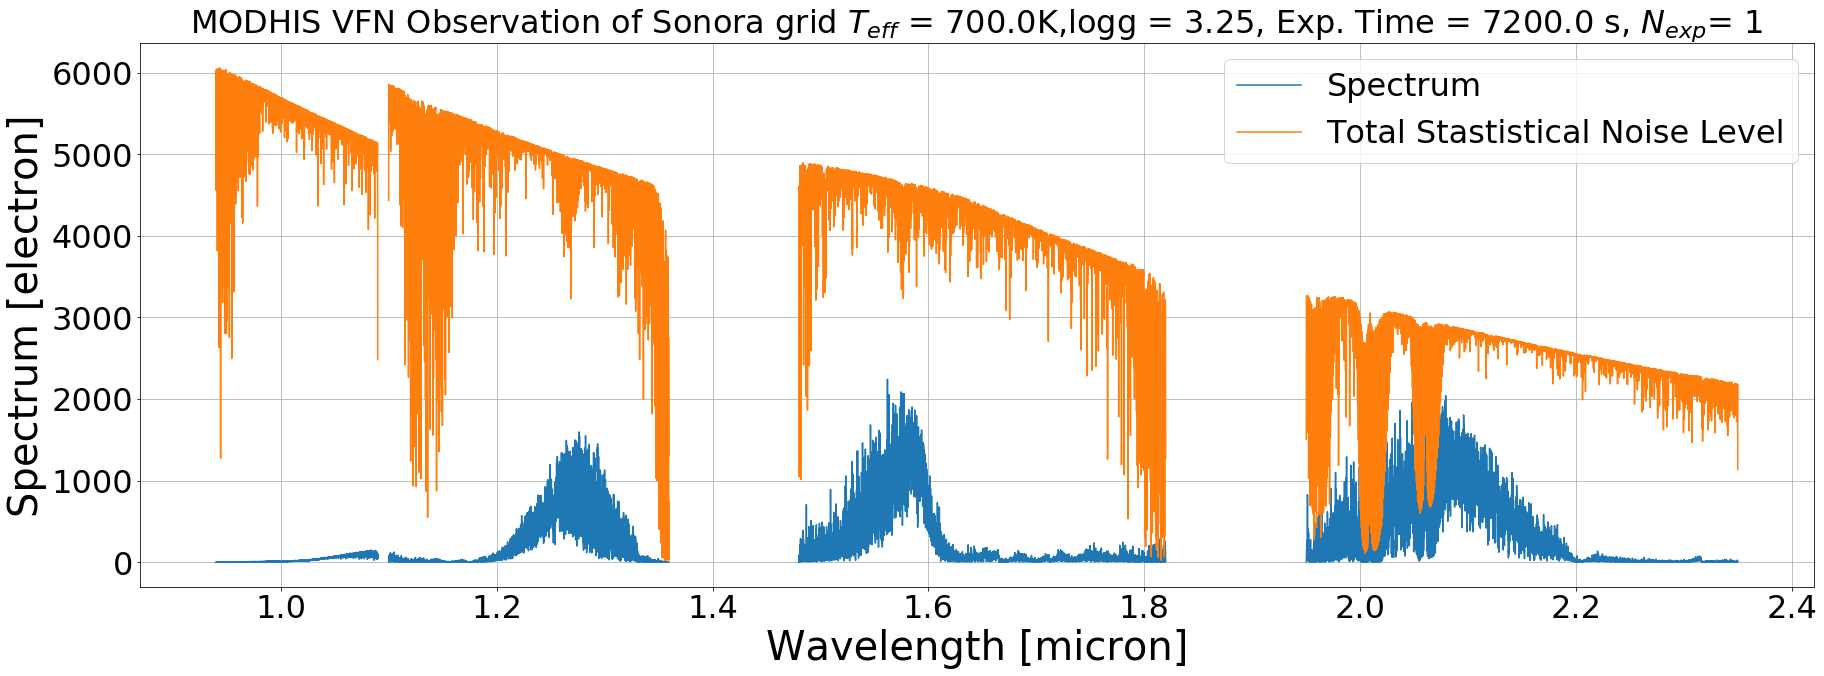

In [15]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum,label="Spectrum")
plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"MODHIS VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,2e3)
plt.grid()

## We can calculate the signal to noise now


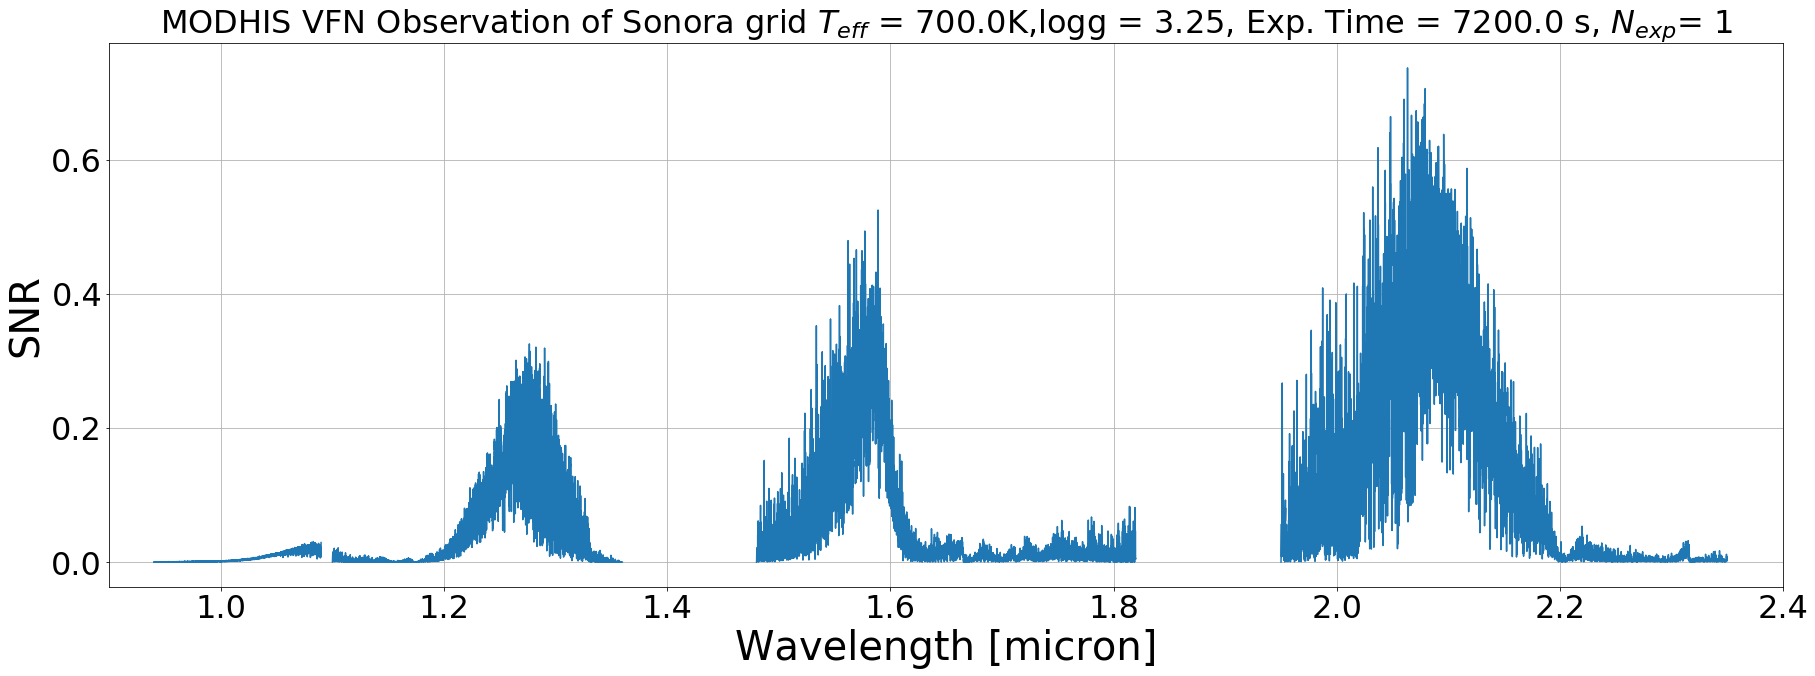

In [16]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum/full_total_noise)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("SNR")

plt.title(r"MODHIS VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))

plt.xlim(0.9,2.4)
plt.grid()

### But let's not forget about systematics. We will estimate our ability to remove the host star spectrum and the telluric lines at the .1% level. 

In [17]:
cal = 0.001 #Telluric calibration accuracy of .1%

#The photon flux at the object will be the stellar flux multipled by the contrast there: 
# full_host_spectrum
host_flux_at_obj = full_host_spectrum*modhis.get_speckle_noise(planet_sep,host_properties['StarAOmag'],"",all_wavelengths,None,tmt)[0]

systematics = (cal*(host_flux_at_obj+full_thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(full_total_noise**2+systematics)

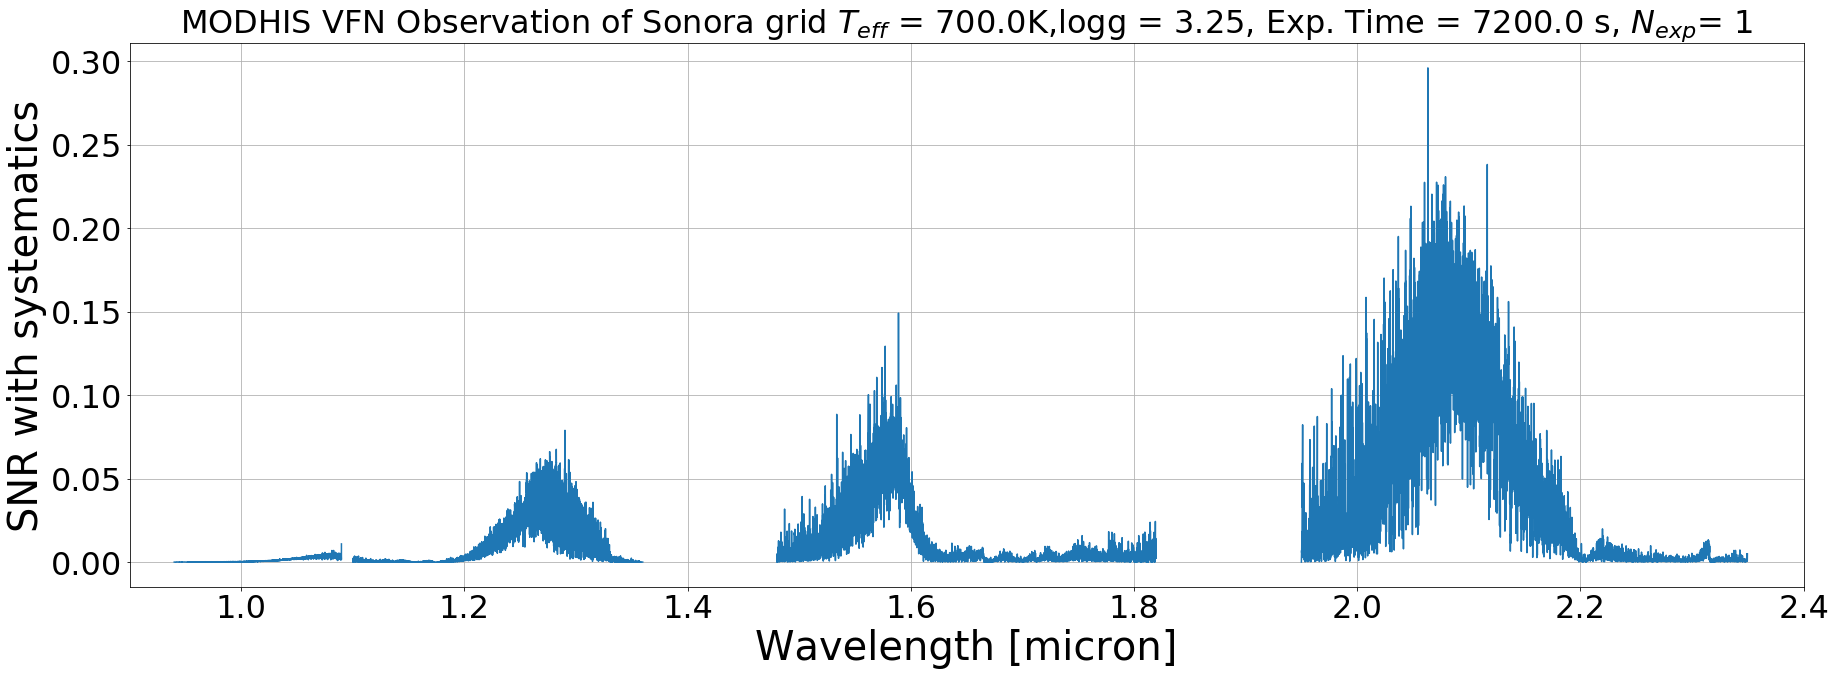

In [18]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum/noise_plus_systematics)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("SNR with systematics")

plt.title(r"MODHIS VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))

plt.xlim(0.9,2.4)
plt.grid()

## Calculate the CCF-SNR

### We'll do this in the K-band (the last one from when we cycled through the filters above)

Since we're doing this in k-band we'll want to recalculate the noise with the systematics just for this band

In [19]:
cal = 0.001 #Telluric calibration accuracy of .1%

#The photon flux at the object will be the stellar flux multipled by the contrast there: 
# full_host_spectrum
host_flux_at_obj = stellar_spec*modhis.get_speckle_noise(planet_sep,host_properties['StarAOmag'],"",wavelengths,None,tmt)[0]

systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(total_noise**2+systematics)


Text(0.5, 0, 'Wavelength [micron]')

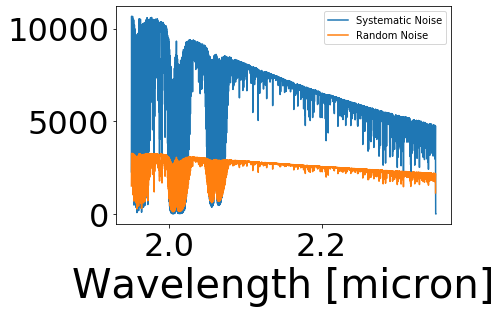

In [20]:
plt.plot(wavelengths,np.sqrt(systematics),label="Systematic Noise")
plt.plot(wavelengths,total_noise,label="Random Noise")
plt.legend(fontsize=10)
plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))

Calculate the sky transmission lines convolved with the line spread function

In [21]:
#Get the wavelength spacing
dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
dwvs[0] = dwvs[1]
dwv_mean = np.mean(dwvs)
lsf_fwhm = (modhis.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma

#Calculate the 
sky_transmission_lsf = gaussian_filter(tmt.get_atmospheric_transmission(wavelengths),
                                                                           lsf_sigma.value)

Now get the ccf snr

In [22]:
ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec, obj_spec_no_sky, noise_plus_systematics, 
                                            sky_transmission_lsf,
                                               systematics_residuals = cal, 
                                               norm_cutoff=0.8)
print(ccf_snr)

4.879023829930416 1 / electron


We can also calculate the ccf SNR for all the bands

# Some other things we can look at to compare with Dimitri's original notebook "HISPEC MODHIS ETC HDC v3"

#### The thermal spectrum of the sky, telecsope and instrument.

(0.9, 2.4)

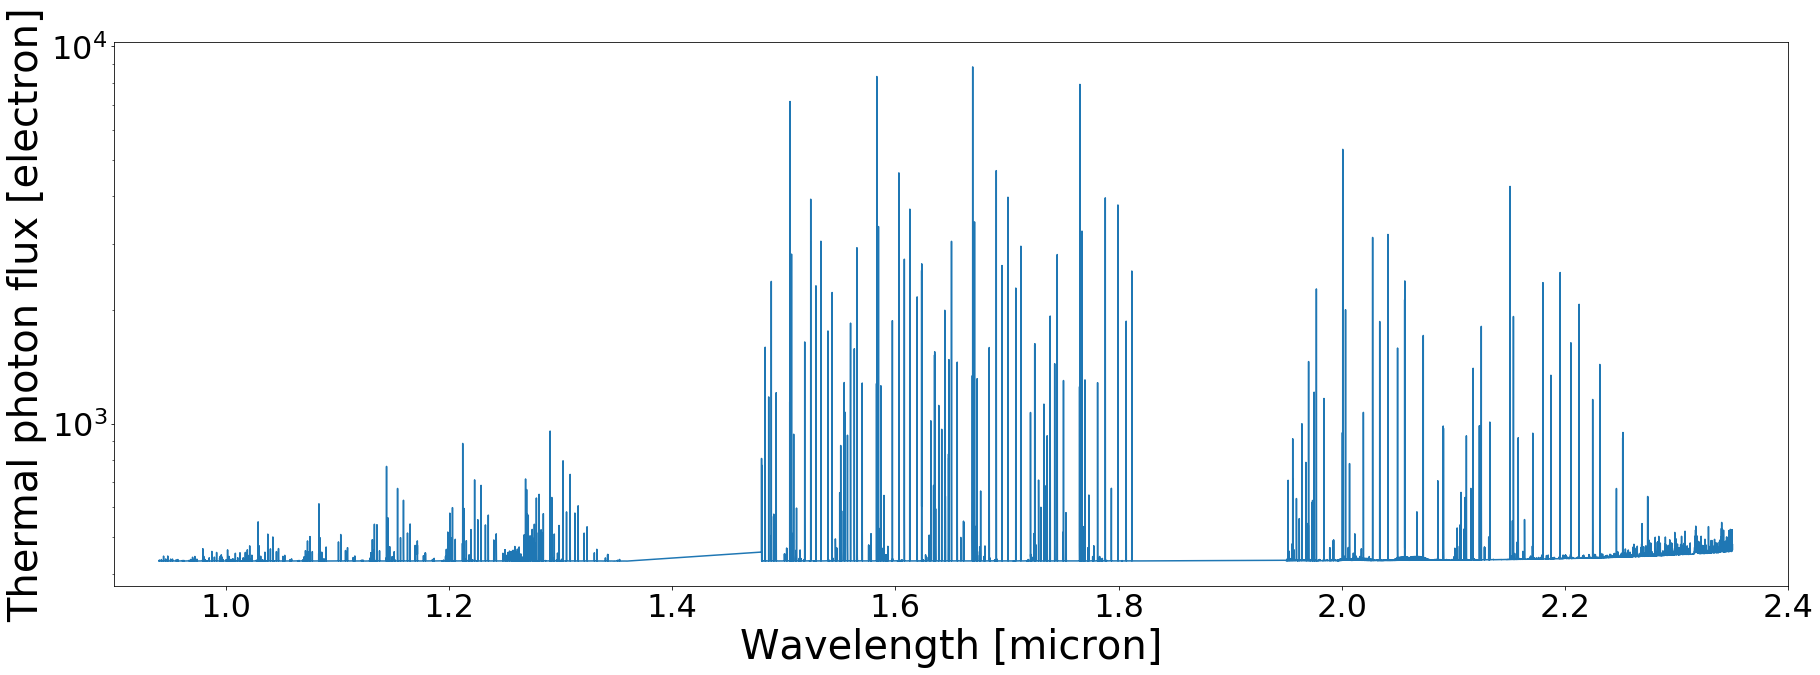

In [23]:
plt.figure(figsize=(30,10))

# plt.semilogy(all_wavelengths,full_host_spectrum)
plt.semilogy(all_wavelengths,full_thermal_spec)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel('Thermal photon flux [{}]'.format(str((full_thermal_spec).unit)))
plt.xlim(0.9,2.4)


### What about the relative contributions of the different noise components

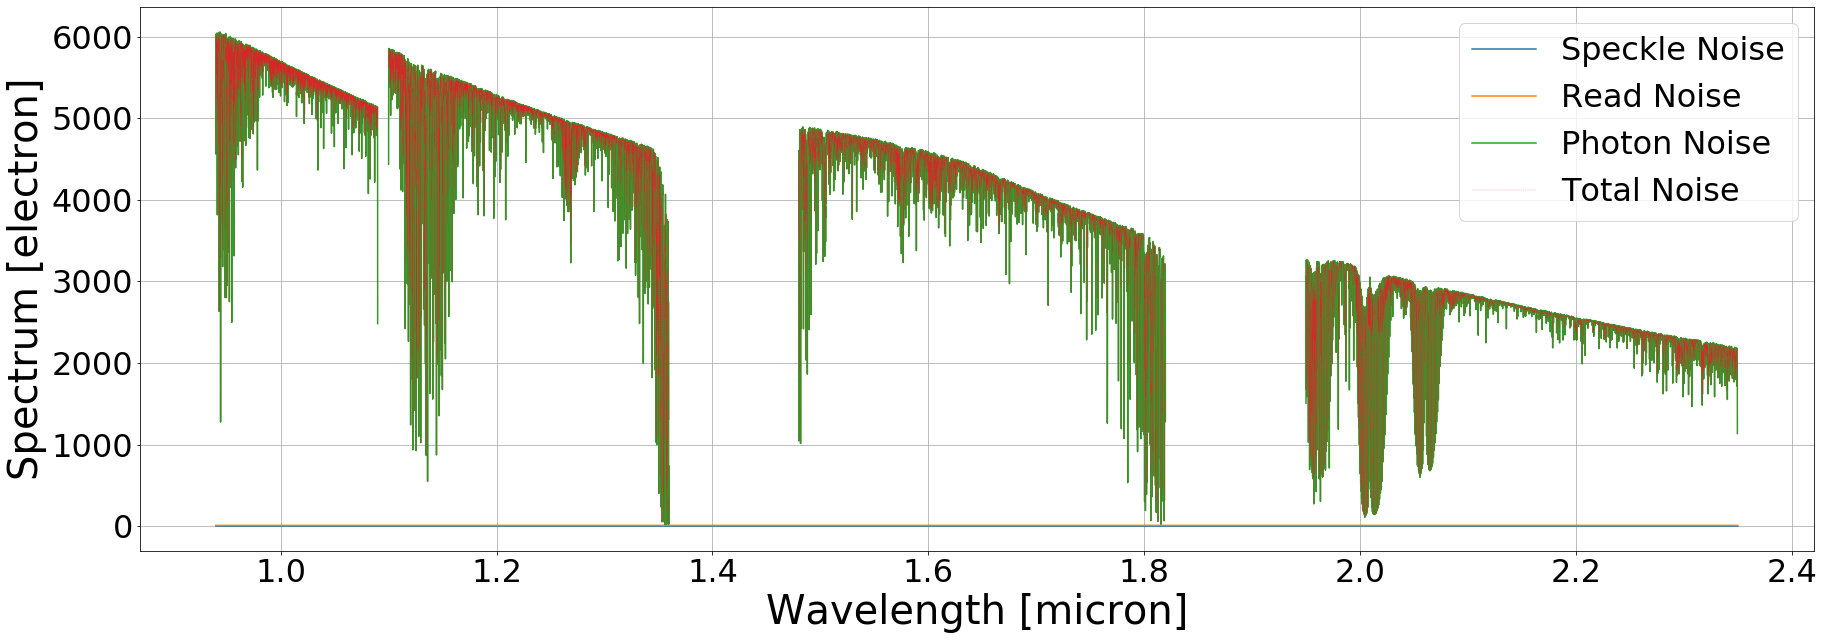

In [24]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_noise_components[0],label="Speckle Noise")
plt.plot(all_wavelengths,full_noise_components[1],label="Read Noise")
# plt.plot(all_wavelengths,full_noise_components[2],label="Dark Current Noise")
plt.plot(all_wavelengths,full_noise_components[2],label="Photon Noise")

plt.plot(all_wavelengths,full_total_noise,linestyle="-.",label="Total Noise",linewidth=0.2)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))

plt.grid()
plt.legend()

## We can also check the throughput of the system: 

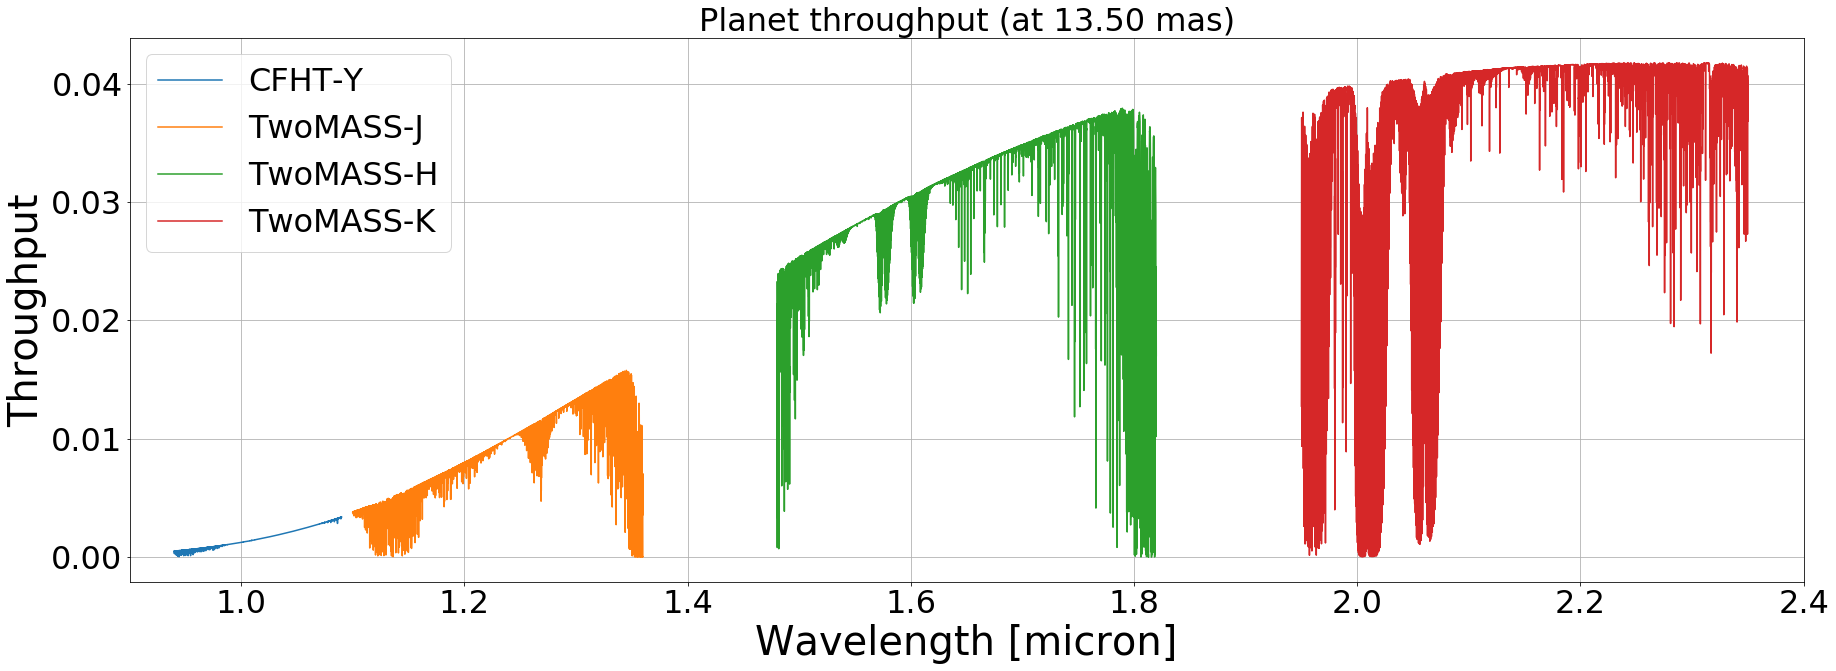

In [25]:
th_sky = []
th_total = []
SR = []

fig = plt.figure(figsize=(30,10))

for modhis_filter in modhis.filters:    
    #Setup the instrument
    modhis.set_current_filter(modhis_filter)
    wavelengths = modhis.get_wavelength_range()
    modhis.set_observing_mode(2*3600,1,modhis_filter, wavelengths,mode='vfn',vortex_charge=1) 
    
    th_sky_tmp = tmt.get_atmospheric_transmission(wavelengths)
    th_sky.append(th_sky_tmp)
    # Set planet_flag=True to include VFN planet injection efficiency
    th_total_tmp = tmt.get_telescope_throughput(wavelengths,modhis.current_filter)*modhis.get_inst_throughput(wavelengths,planet_flag=True,planet_sep=planet_sep)*modhis.get_filter_transmission(wavelengths,modhis.current_filter)
    th_total.append(th_total_tmp)
    SR.append(modhis.compute_SR(wavelengths))            
    
    #Dan TODO: not sure what this next line is supposed to plot. What's the 0.95 coeff for? Why recalculate everything
    #plt.plot(wavelengths,0.95*keck.get_atmospheric_transmission(wavelengths)*keck.get_telescope_throughput(wavelengths,kpic)*kpic.get_inst_throughput(wavelengths)*kpic.get_filter_transmission(wavelengths,kpic.current_filter),label=kpic_filter)
    
    plt.plot(wavelengths, th_sky_tmp*th_total_tmp, label=modhis_filter)
    

th_sky = np.hstack(th_sky)
th_total = np.hstack(th_total)
SR = np.hstack(SR)

plt.xlim(0.9,2.4)
#plt.ylim(0,0.15)
plt.grid()
plt.xlabel("Wavelength [micron]")
plt.ylabel("Throughput")
plt.title('Planet throughput (at %0.2f mas)'%host_properties['AngSep'].to(u.mas).value)

plt.legend()

## And the Strehl Ratio

(0.9, 2.4)

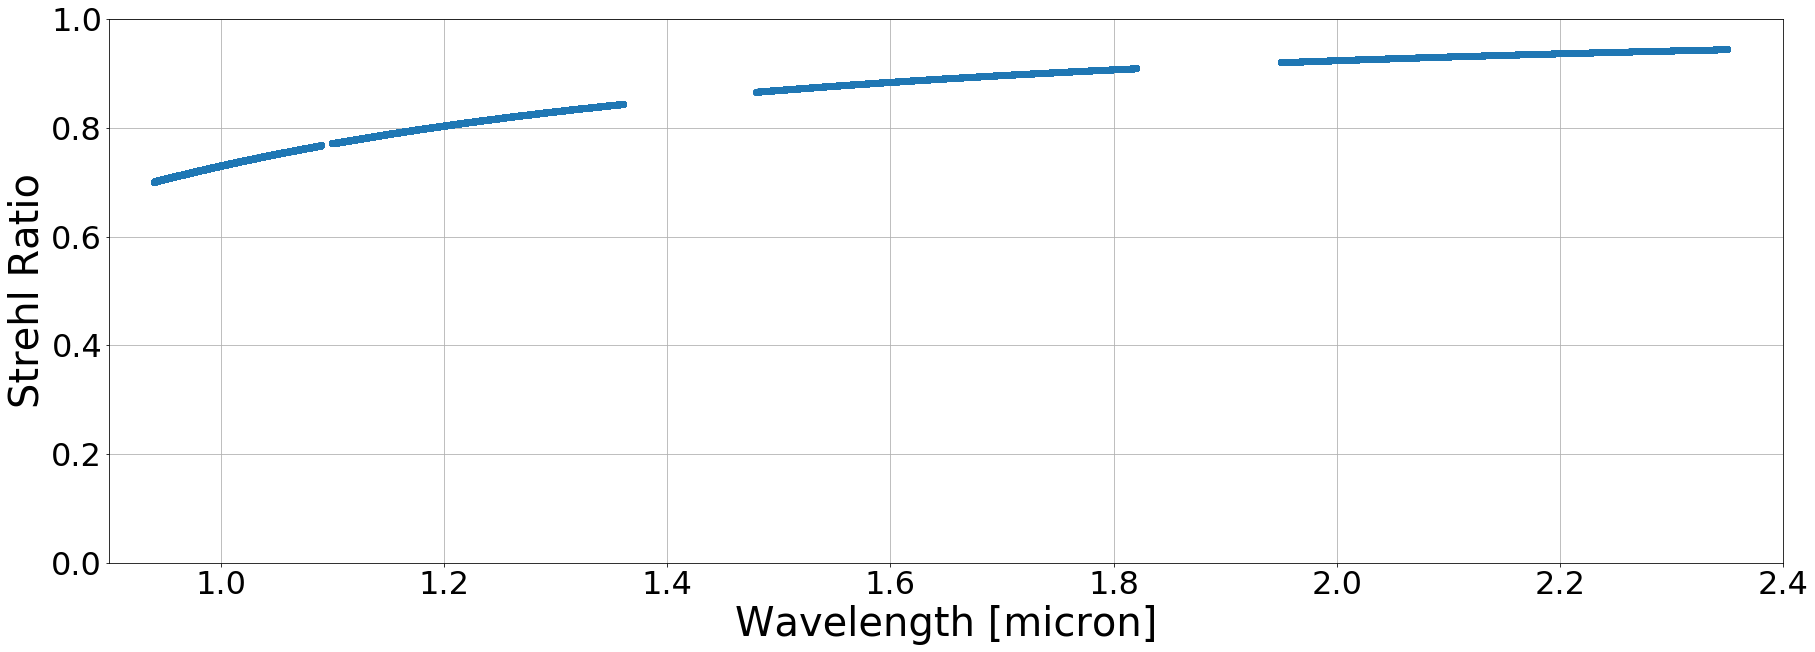

In [26]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,SR,'o')

# plt.ylim(1e-2,0.2)
plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Strehl Ratio")
# plt.ylim(1e-4,1e2)
plt.grid()
plt.ylim(0,1)
plt.xlim(0.9,2.4)

## Check the contrasts and mark the 0.4 arcsecond location for each wavelength

Note: the VFN contrast is independent of the target's position; it depends only on the WFE and Tip/Tilt residuals in the observation.

(7.5, 20)

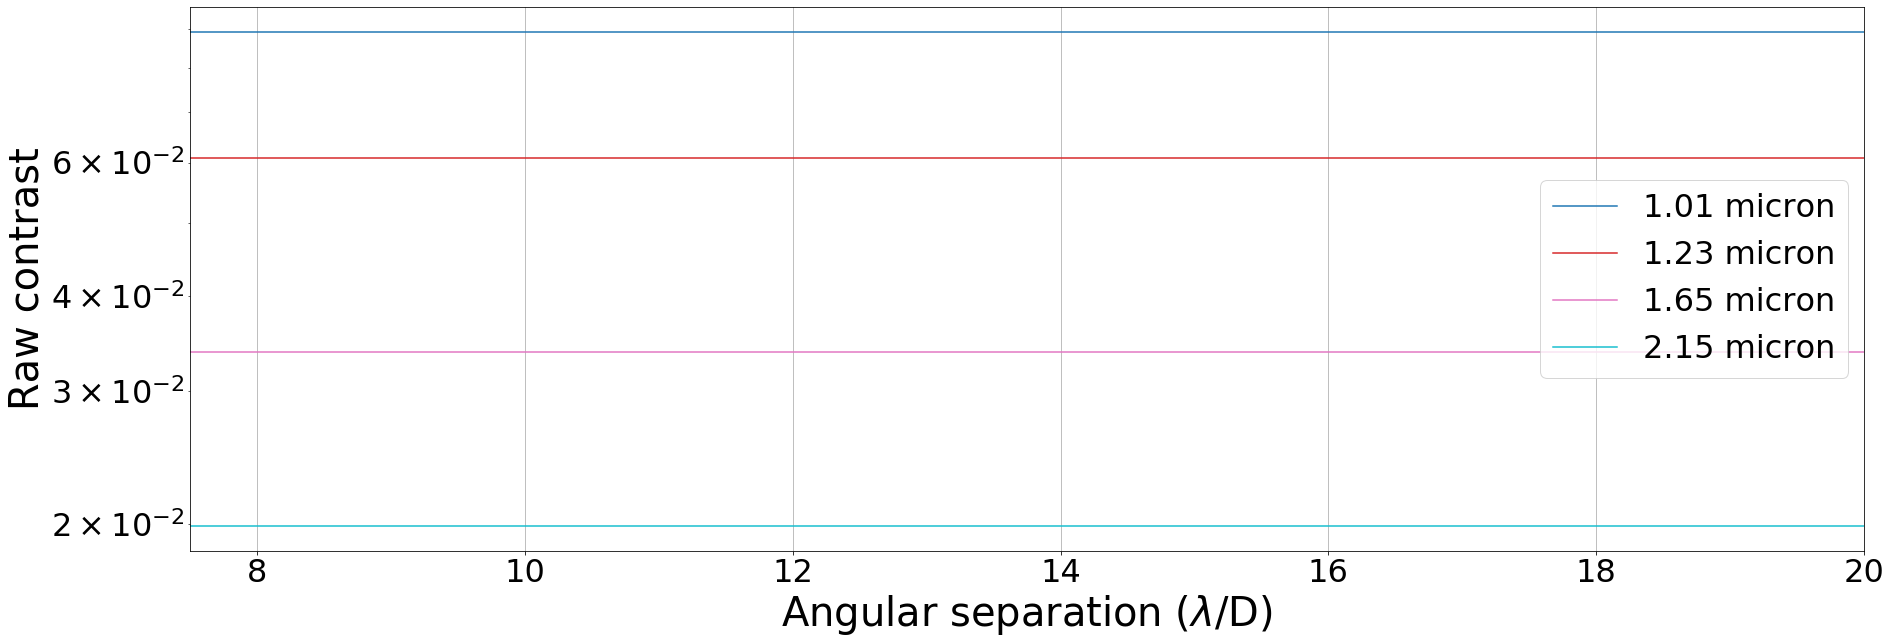

In [27]:
separations = np.arange(0,1.,0.001)*u.arcsecond

plt.figure(figsize=(30,10))

for modhis_filter in modhis.filters:
    
    modhis.set_current_filter(modhis_filter)
    wavelengths = modhis.get_wavelength_range()
    modhis.set_observing_mode(2*3600,1,modhis_filter, wavelengths,mode='vfn',vortex_charge=1) 
    
#     print(wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2])
    
    contrasts = modhis.get_speckle_noise(separations,host_properties["StarAOmag"],modhis.current_filter,
                                       wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2],
                                         host_properties['StarSpT'],tmt)[:,0]
    
    tsts = modhis.get_speckle_noise(np.array([0.4,0.5,0.6])*u.arcsecond,host_properties["StarAOmag"],
                                       modhis.current_filter,
                                       wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2],
                                       host_properties['StarSpT'],tmt)[0]
    
    plt.semilogy(separations/206265*tmt.diameter/np.mean(wavelengths).to(u.m),contrasts,
                 label="{:.2f}".format(np.mean(wavelengths)))
    plt.axvline(0.4/206265*tmt.diameter/np.mean(wavelengths).to(u.m))
    plt.plot([0.4/206265*tmt.diameter/np.mean(wavelengths).to(u.m)],[tsts],'o')
    
plt.xlabel('Angular separation ($\lambda$/D)')
plt.ylabel('Raw contrast')
plt.legend()

plt.grid(True)
plt.xlim(7.5,20)